This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Simple fuzzy echo classification from dual-pol moments 

In [1]:
import wradlib
from wradlib.util import get_wradlib_data_file
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import xarray as xr

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

## Setting the file paths

In [2]:
rhofile = get_wradlib_data_file("netcdf/TAG-20120801-140046-02-R.nc")
phifile = get_wradlib_data_file("netcdf/TAG-20120801-140046-02-P.nc")
reffile = get_wradlib_data_file("netcdf/TAG-20120801-140046-02-Z.nc")
dopfile = get_wradlib_data_file("netcdf/TAG-20120801-140046-02-V.nc")
zdrfile = get_wradlib_data_file("netcdf/TAG-20120801-140046-02-D.nc")
mapfile = get_wradlib_data_file("hdf5/TAG_cmap_sweeps_0204050607.hdf5")

## Read the data (radar moments and static clutter map)

In [3]:
# We need to organize our data as a dictionary
dat = {}
dat["rho"], attrs_rho = wradlib.io.read_edge_netcdf(rhofile)
dat["phi"], attrs_phi = wradlib.io.read_edge_netcdf(phifile)
dat["ref"], attrs_ref = wradlib.io.read_edge_netcdf(reffile)
dat["dop"], attrs_dop = wradlib.io.read_edge_netcdf(dopfile)
dat["zdr"], attrs_zdr = wradlib.io.read_edge_netcdf(zdrfile)
dat["map"] = wradlib.io.from_hdf5(mapfile)[0][0]

dat = {k: (["azimuth", "range"], v) for k, v in dat.items()}

In [4]:
az, rng = dat["rho"][1].shape
swp = xr.Dataset(dat, coords={"azimuth": np.arange(az), "range": np.arange(rng)})
swp = swp.assign_coords(
    dict(
        longitude=7,
        latitude=53,
        altitude=0,
        elevation=1,
        sweep_mode="azimuth_surveillance",
    )
)
swp = swp.wrl.georef.georeference()
display(swp)

<xarray.Dataset> Size: 6MB
Dimensions:     (azimuth: 360, range: 240)
Coordinates: (12/14)
  * azimuth     (azimuth) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * range       (range) int64 2kB 0 1 2 3 4 5 6 ... 233 234 235 236 237 238 239
    longitude   int64 8B 7
    latitude    int64 8B 53
    altitude    int64 8B 0
    elevation   int64 8B 1
    ...          ...
    y           (azimuth, range) float64 691kB 0.0 0.9998 2.0 ... 237.9 238.9
    z           (azimuth, range) float64 691kB 0.0 0.01745 ... 4.157 4.174
    gr          (azimuth, range) float64 691kB 0.0 0.9998 2.0 ... 238.0 239.0
    rays        (azimuth, range) int64 691kB 0 0 0 0 0 0 ... 359 359 359 359 359
    bins        (azimuth, range) int64 691kB 0 1 2 3 4 5 ... 235 236 237 238 239
    crs_wkt     int64 8B 0
Data variables:
    rho         (azimuth, range) float32 346kB 0.8743 0.751 ... 0.2174 0.2788
    phi         (azimuth, range) float32 346kB 50.12 50.12 50.12 ... nan nan nan
    ref         (azimuth, range) float32 346kB -15.5 -18.5 -12.0 ... nan nan nan
    dop         (azimuth, range) float32 346kB -0.4297 -0.4297 ... nan nan
    zdr         (azimuth, range) float32 346kB 8.0 -7.059 -0.1882 ... nan nan
    map         (azimuth, range) bool 86kB True True True ... False False False

## Identify non-meteorological echoes using fuzzy echo classification

See [Crisologo et al. (2015)](https://link.springer.com/article/10.1007/s13143-014-0049-y) and [Vulpiani et al. (2012)](https://journals.ametsoc.org/doi/abs/10.1175/JAMC-D-10-05024.1) for details.

In [5]:
moments = dict(rho="rho", phi="phi", ref="ref", dop="dop", zdr="zdr", map="map")
weights = {"zdr": 0.4, "rho": 0.4, "rho2": 0.4, "phi": 0.1, "dop": 0.1, "map": 0.5}
prob, nanmask = swp.wrl.classify.classify_echo_fuzzy(moments, weights=weights)
thresh = 0.5
cmap = prob.where(prob < thresh, True, False)

## View classfication results

Text(0, 0.5, '# bins from radar')

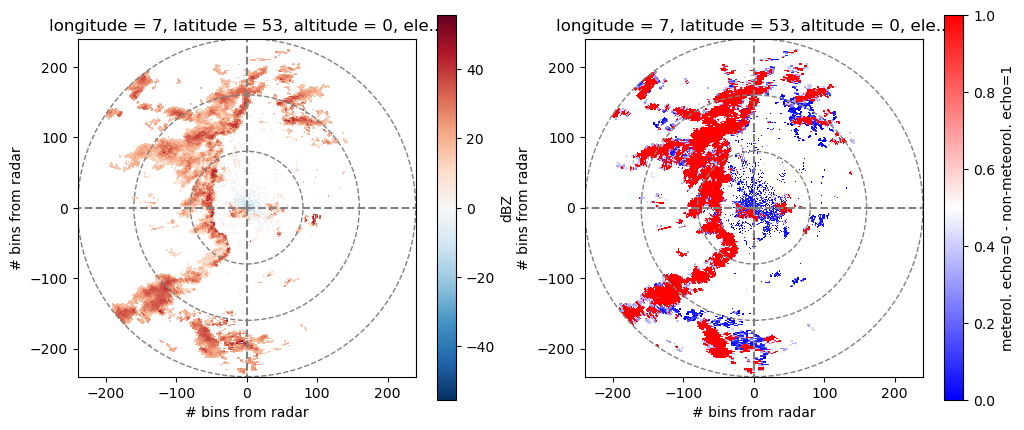

In [6]:
fig = plt.figure(figsize=(12, 5))

# Horizontal reflectivity
ax = plt.subplot(121, aspect="equal")
pm = swp.ref.plot(x="x", y="y", ax=ax, cbar_kwargs=dict(label="dBZ"))
ax = wradlib.vis.plot_ppi_crosshair(site=(0, 0, 0), ranges=[80, 160, 240])
plt.xlim(-240, 240)
plt.ylim(-240, 240)
plt.xlabel("# bins from radar")
plt.ylabel("# bins from radar")

# Echo classification
ax = plt.subplot(122, aspect="equal")
pm = cmap.where(~np.isnan(swp.ref)).plot(
    x="x",
    y="y",
    ax=ax,
    cmap="bwr",
    cbar_kwargs=dict(label="meterol. echo=0 - non-meteorol. echo=1"),
)
ax = wradlib.vis.plot_ppi_crosshair(site=(0, 0, 0), ranges=[80, 160, 240])
plt.xlim(-240, 240)
plt.ylim(-240, 240)
plt.xlabel("# bins from radar")
plt.ylabel("# bins from radar")